# Basketball Noodling

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

from bs4 import BeautifulSoup
import re
from pprint import pprint

import requests
from pathlib import Path

## Get a few box scores

In [2]:
data_path = Path("/Users/rory/data/ncaa_stats/box_score")

cu_game_ids = [
    5736833,
    5731718,
    5736837,
]

In [3]:
def box_score_html(game_id):
    """Downloads and saves a box score HTML page from NCAA Stats

    Parameters
    ----------
    game_id : int
        NCAA game ID

    Returns
    -------
        str
            The content of the downloaded HTML file, or None if an error occurred.
    """
    html_path = data_path / f"{game_id}.html"
    if html_path.exists():
        print("Got this one", game_id)
        return html_path.read_text()

    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    url = "https://stats.ncaa.org/contests/5731718/box_score"
    r = requests.get(url, headers=headers)

    if not r.ok:
        print("Problem", r.text)

    html_path.write_bytes(r.content)
    return r.text

In [4]:
html_content = box_score_html(5736837)

Got this one 5736837


In [5]:
soup = BeautifulSoup(html_content)

# Updated regex pattern for the specific `addShot` format you provided
shot_data_pattern = re.compile(
    r"addShot\(\s*([\d.]+),\s*([\d.]+),\s*(\d+),\s*(true|false),\s*(\d+),\s*'([^']+)',\s*'([^']+)',\s*(true|false)\s*\);"
)

shot_data = []

for script in soup.find_all("script"):
    if script.string and shot_data_pattern.search(script.string):
        for match in shot_data_pattern.findall(script.string):
            # Map matched groups to relevant fields
            shot = {
                "x": float(match[0]),  # X-coordinate
                "y": float(match[1]),  # Y-coordinate
                "team_id": int(match[2]),  # Team ID
                "made": match[3] == "true",  # Shot success (True if 'made')
                "player_id": int(match[4]),  # Player ID
                "description": match[5],  # Shot description
                "meta_info": match[6],  # Additional metadata
                "flag": match[7] == "true",  # Extra boolean flag, if needed
            }
            shot_data.append(shot)


# Extract teams and players from the dropdowns
teams = {}
for option in soup.select("#team_select option"):
    if option.get("value").isdigit():
        teams[int(option["value"])] = option.text.strip()

players = {}
for optgroup in soup.select("#player_select optgroup"):
    team = optgroup.get("label")
    players[team] = {
        int(option["value"]): option.text.strip()
        for option in optgroup.find_all("option")
    }

# Print results
# print("Shot Data:", shot_data)
print("Teams:", teams)
print("Players by Team:")
pprint(players)

Teams: {157: 'Colorado', 811: 'Wyoming'}
Players by Team:
{'Colorado': {775989920: 'Nyamer Diew',
              775989921: 'Lior Garzon',
              775989922: 'Johanna Teder',
              775989923: 'Sara-Rose Smith',
              775989924: 'Kindyll Wetta',
              775989925: 'Jade Masogayo',
              775989926: 'Kennedy Sanders',
              775989927: 'Ayianna Johnson',
              775989928: 'Tabitha Betson'},
 'Wyoming': {775989908: 'Ola Ustowska',
             775989909: 'Malene Pedersen',
             775989910: 'Emily Mellema',
             775989911: 'Tess Barnes',
             775989912: 'Allyson Fertig',
             775989913: 'Payton Muma',
             775989914: 'Mikyn Hamlin',
             775989915: 'Kati Ollilainen',
             775989916: 'Madi Symons',
             775989917: 'Logann Alvar'}}


In [31]:
shot_df = pd.DataFrame(shot_data)
shot_df.head()

,x,y,team_id,made,player_id,description,meta_info,flag
0,91.0,43.0,157,False,2680563039,1st 09:39:00 : missed by Nyamer Diew(Colorado)...,period_1 player_775989920 team_157,False
1,11.0,54.0,811,False,2680563041,1st 09:26:00 : missed by Emily Mellema(Wyoming...,period_1 player_775989910 team_811,False
2,90.0,52.0,157,True,2680563045,1st 09:08:00 : made by Tabitha Betson(Colorado...,period_1 player_775989928 team_157,False
3,24.0,43.0,811,False,2680563046,1st 08:42:00 : missed by Emily Mellema(Wyoming...,period_1 player_775989910 team_811,False
4,15.0,94.0,811,True,2680563048,1st 08:33:00 : made by Ola Ustowska(Wyoming) 2-3,period_1 player_775989908 team_811,False


In [10]:
def draw_full_ncaa_court(ax=None, color="black", lw=2):
    if ax is None:
        ax = plt.gca()

    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)

    hoop_left = patches.Circle(
        (5.25, 25), radius=0.75, linewidth=lw, color=color, fill=False
    )
    hoop_right = patches.Circle(
        (88.75, 25), radius=0.75, linewidth=lw, color=color, fill=False
    )

    backboard_left = patches.Rectangle((4, 22), 0.2, 6, linewidth=lw, color=color)
    backboard_right = patches.Rectangle((89.8, 22), 0.2, 6, linewidth=lw, color=color)

    paint_left = patches.Rectangle(
        (0, 19), 19, 12, linewidth=lw, color=color, fill=False
    )
    paint_right = patches.Rectangle(
        (75, 19), 19, 12, linewidth=lw, color=color, fill=False
    )

    free_throw_circle_left = patches.Circle(
        (19, 25), 6, linewidth=lw, color=color, fill=False
    )
    free_throw_circle_right = patches.Circle(
        (75, 25), 6, linewidth=lw, color=color, fill=False
    )

    restricted_left = patches.Arc(
        (5.25, 25), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color
    )
    restricted_right = patches.Arc(
        (88.75, 25), 8, 8, theta1=0, theta2=180, linewidth=lw, color=color
    )

    # Define three-point arcs and lines
    three_point_arc_left = patches.Arc(
        (5.25, 25), 44.3, 44.3, theta1=-68, theta2=68, linewidth=lw, color=color
    )
    three_point_arc_right = patches.Arc(
        (88.75, 25), 44.3, 44.3, theta1=112, theta2=248, linewidth=lw, color=color
    )
    corner_three_left = patches.Rectangle((0, 19), 3, 12, linewidth=lw, color=color)
    corner_three_right = patches.Rectangle((91, 19), 3, 12, linewidth=lw, color=color)

    # Define center court circle
    center_circle = patches.Circle((47, 25), 6, linewidth=lw, color=color, fill=False)

    # Define half-court line
    half_court_line = patches.Rectangle((47, 0), 0.2, 50, linewidth=lw, color=color)

    # Add all elements to the court
    court_elements = [
        hoop_left,
        hoop_right,
        backboard_left,
        backboard_right,
        paint_left,
        paint_right,
        free_throw_circle_left,
        free_throw_circle_right,
        # restricted_left,
        # restricted_right,
        three_point_arc_left,
        three_point_arc_right,
        corner_three_left,
        corner_three_right,
        center_circle,
        half_court_line,
    ]
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [26]:
def plot_shots(shot_data: list):
    fig, ax = plt.subplots(figsize=(14, 7))
    draw_full_ncaa_court(ax)

    for shot in shot_data:
        color = "blue" if shot["team_id"] == 157 else "red"  # Different colors for teams
        marker = (
            "o" if shot["made"] else "x"
        )  # Made shots are circles, missed shots are crosses
        ax.scatter(
            shot["x"] * 94 / 100, shot["y"] * 50 / 100, color=color, marker=marker, s=100
        )


    # Set axis properties
    plt.title("NCAA Full Basketball Court")
    plt.xlabel("Court Length (feet)")
    plt.ylabel("Court Width (feet)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.show()

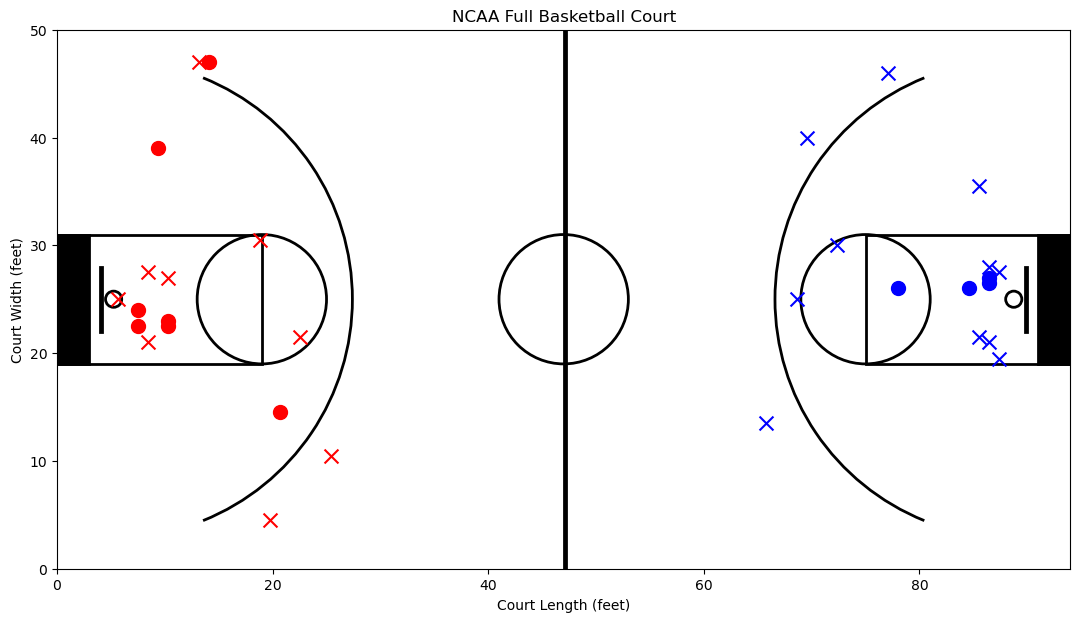

In [27]:
plot_shots(shot_df[shot_df.meta_info.str.contains("period_1")].to_dict("records"))

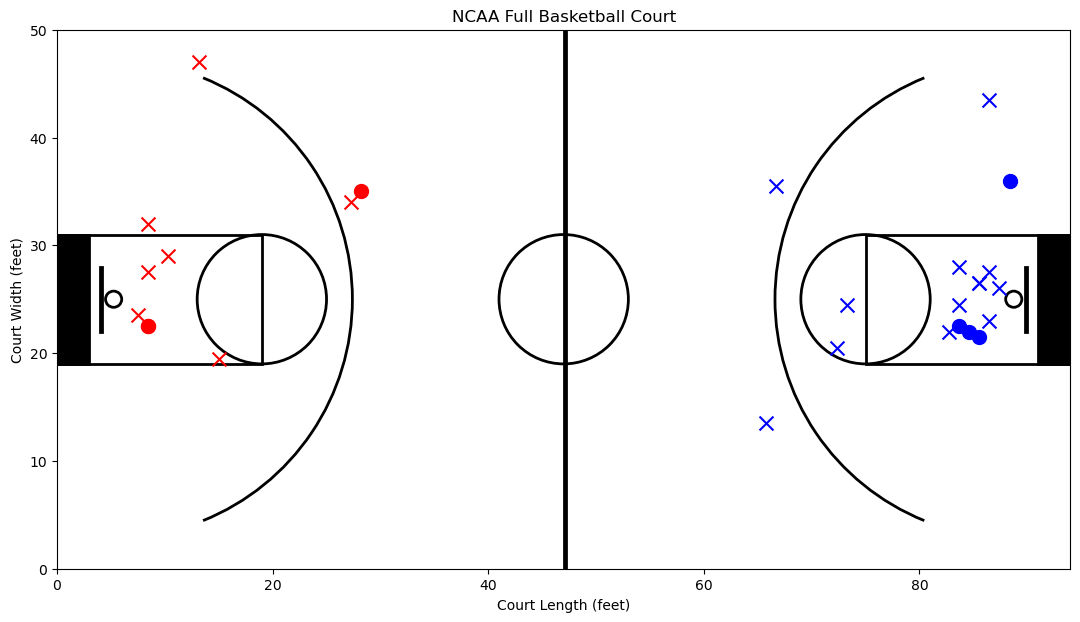

In [28]:
plot_shots(shot_df[shot_df.meta_info.str.contains("period_2")].to_dict("records"))

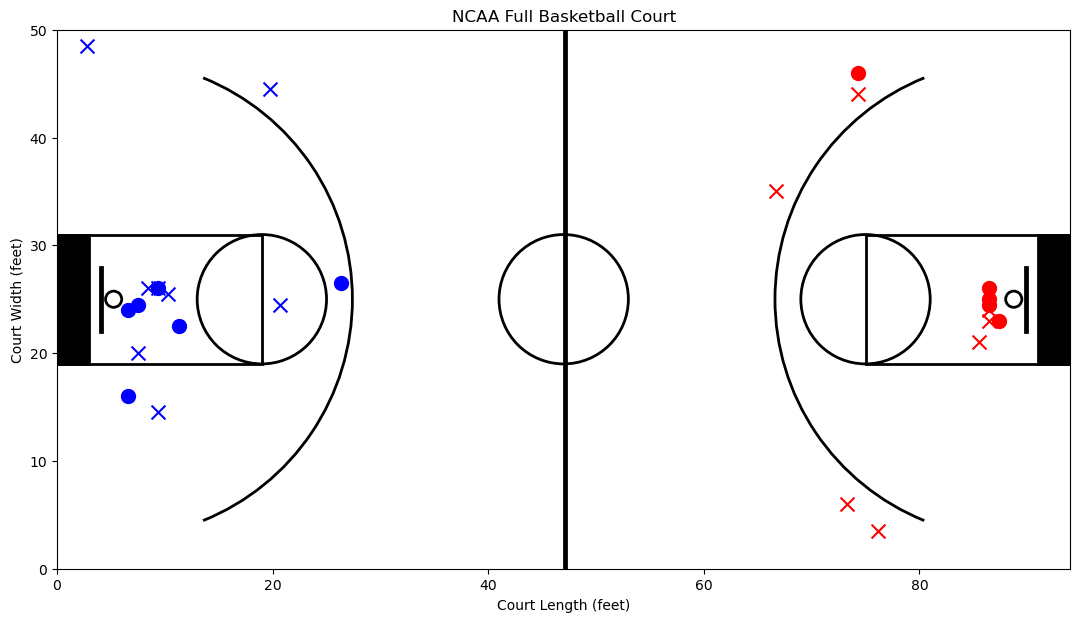

In [30]:
plot_shots(shot_df[shot_df.meta_info.str.contains("period_4")].to_dict("records"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883731 entries, 0 to 1883730
Data columns (total 59 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   id                               int64  
 1   sequence_number                  int64  
 2   type_id                          int64  
 3   type_text                        object 
 4   text                             object 
 5   away_score                       int64  
 6   home_score                       int64  
 7   period_number                    int64  
 8   period_display_value             object 
 9   clock_display_value              object 
 10  scoring_play                     bool   
 11  score_value                      int64  
 12  team_id                          float64
 13  athlete_id_1                     float64
 14  wallclock                        object 
 15  shooting_play                    bool   
 16  season                           int64  
 17  season_t

In [4]:
df.head()

,id,sequence_number,type_id,type_text,text,away_score,home_score,period_number,period_display_value,clock_display_value,...,lag_qtr,lag_game_half,athlete_id_2,game_date,game_date_time,coordinate_x_raw,coordinate_y_raw,coordinate_x,coordinate_y,media_id
0,401528028101900000,101899901,615,Jumpball,Jump Ball won by LSU,0,0,1,1st Quarter,10:00,...,NaN,NaN,NaN,2023-04-02,2023-04-02T19:30:00Z,25.0,0.0,-41.75,0.0,NaN
1,401528028101905000,101904601,598,Lost Ball Turnover,Flau'jae Johnson Turnover.,0,0,1,1st Quarter,9:53,...,1.0,1.0,NaN,2023-04-02,2023-04-02T19:30:00Z,25.0,0.0,-41.75,0.0,NaN
2,401528028101905000,101904602,607,Steal,Gabbie Marshall Steal.,0,0,1,1st Quarter,9:53,...,1.0,1.0,NaN,2023-04-02,2023-04-02T19:30:00Z,25.0,0.0,41.75,0.0,NaN
3,401528028101906000,101906301,558,JumpShot,Monika Czinano made Jumper. Assisted by Caitli...,0,2,1,1st Quarter,9:36,...,1.0,1.0,4433403.0,2023-04-02,2023-04-02T19:30:00Z,30.0,0.0,41.75,-5.0,NaN
4,401528028101908000,101908101,558,JumpShot,Flau'jae Johnson made Three Point Jumper. Assi...,3,2,1,1st Quarter,9:18,...,1.0,1.0,4281251.0,2023-04-02,2023-04-02T19:30:00Z,48.0,1.0,-40.75,23.0,NaN


In [7]:
[n for n in df.home_team_name.unique() if "Colorado" in n]

['Colorado', 'Colorado State', 'Northern Colorado']

In [8]:
df[df.home_team_name == "Colorado"]

,id,sequence_number,type_id,type_text,text,away_score,home_score,period_number,period_display_value,clock_display_value,...,lag_qtr,lag_game_half,athlete_id_2,game_date,game_date_time,coordinate_x_raw,coordinate_y_raw,coordinate_x,coordinate_y,media_id
24863,401527982101900000,101899901,615,Jumpball,Jump Ball won by Colorado,0,0,1,1st Quarter,10:00,...,NaN,NaN,NaN,2023-03-18,2023-03-18T23:00:00Z,25.0,0.0,41.75,0.0,NaN
24864,401527982101906000,101906401,558,JumpShot,Jaylyn Sherrod missed Jumper.,0,0,1,1st Quarter,9:35,...,1.0,1.0,NaN,2023-03-18,2023-03-18T23:00:00Z,19.0,14.0,27.75,6.0,NaN
24865,401527982101906000,101906402,587,Defensive Rebound,Anastasiia Boldyreva Defensive Rebound.,0,0,1,1st Quarter,9:35,...,1.0,1.0,NaN,2023-03-18,2023-03-18T23:00:00Z,25.0,0.0,-41.75,0.0,NaN
24866,401527982101908000,101907801,519,PersonalFoul,Foul on Tayanna Jones.,0,0,1,1st Quarter,9:21,...,1.0,1.0,NaN,2023-03-18,2023-03-18T23:00:00Z,25.0,0.0,41.75,0.0,NaN
24867,401527982101908000,101907802,540,MadeFreeThrow,Savannah Wheeler made Free Throw.,1,0,1,1st Quarter,9:21,...,1.0,1.0,NaN,2023-03-18,2023-03-18T23:00:00Z,25.0,0.0,-41.75,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836405,401494323105000000,104999803,618,Block Shot,Brianna McLeod Block.,53,85,4,4th Quarter,0:01,...,4.0,2.0,NaN,2022-11-07,2022-11-07T19:00:00Z,NaN,NaN,NaN,NaN,NaN
1836406,401494323105000000,104999804,586,Offensive Rebound,New Mexico State Offensive Rebound.,53,85,4,4th Quarter,0:01,...,4.0,2.0,NaN,2022-11-07,2022-11-07T19:00:00Z,NaN,NaN,NaN,NaN,NaN
1836407,401494323105000000,104999805,558,JumpShot,Taylor Donaldson made Jumper. Assisted by Sian...,55,85,4,4th Quarter,0:01,...,4.0,2.0,4899947.0,2022-11-07,2022-11-07T19:00:00Z,NaN,NaN,NaN,NaN,NaN
1836408,401494323105000000,104999901,412,End Period,End of 4th Quarter,55,85,4,4th Quarter,0:00,...,4.0,2.0,NaN,2022-11-07,2022-11-07T19:00:00Z,NaN,NaN,NaN,NaN,NaN
